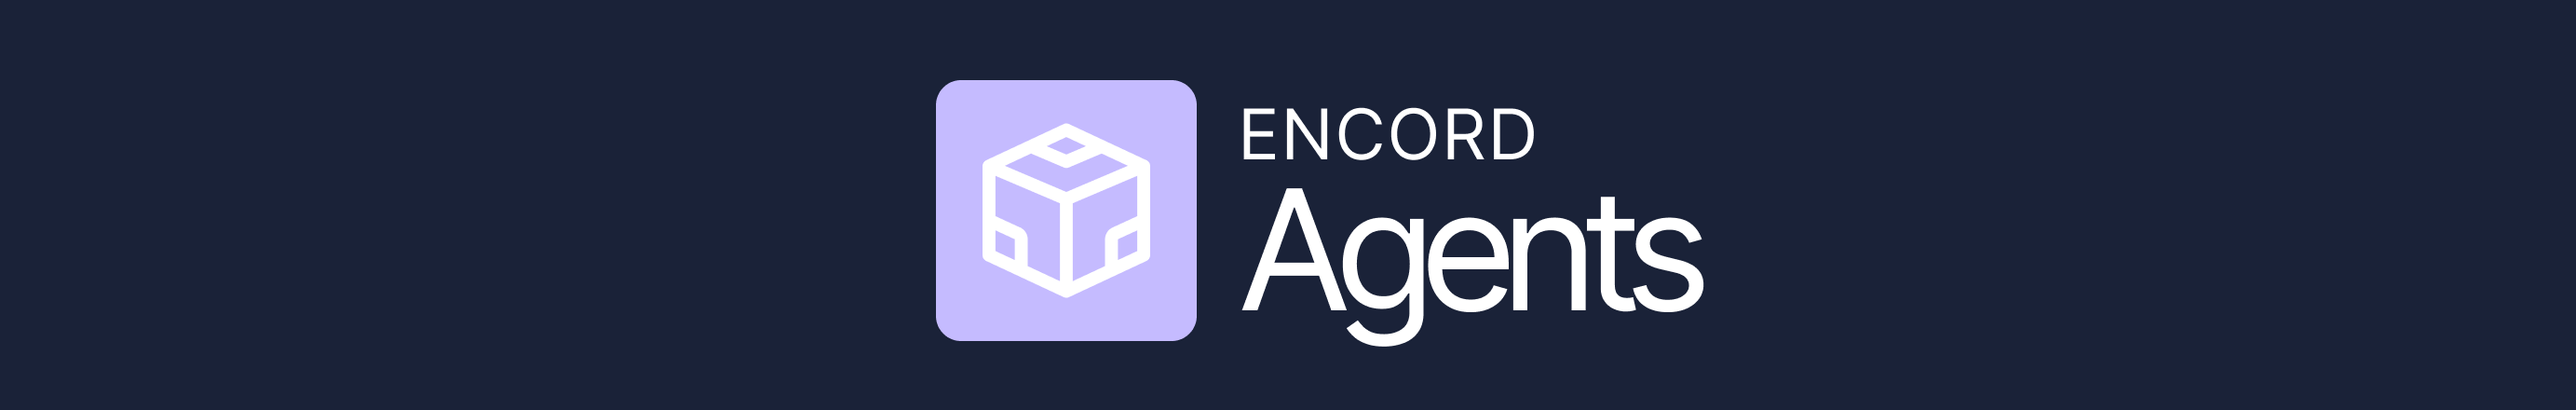

Inspired by the approach used in the [CogX Video model](https://github.com/THUDM/CogVideo) this notebook:

1. Uses a VLM to generate frame-specific captions.
2. Compile these captions into a textual summary using an LLM.

> 💡 This method is most effective for shorter clips with minimal scene changes.  

CogVideoX leverages these captioned videos to train text-to-video models, and similar workflows can be applied to other multimodal generative AI applications.

## Installation

Ensure that you install:
- The `encord-agents` library.
- The `openai` library.

In [ ]:
!python -m pip install encord-agents[opencv-headless] openai

## Authentication

The Encord agents library authenticates using ssh keys, and OpenAI using an API key. The following code cell for setting the `ENCORD_SSH_KEY` and `OPENAI_API_KEY`environment variables. It must contain the raw content of your private ssh key file and OpenAI API key.

> - Replace `private_key_file_content` with your Encord private key.
> - Replace `api_key_file_content` with your OpenAI API key.

If you have not yet setup an ssh key, please follow the [documentation](https://agents-docs.encord.com/authentication/).

> 💡 In the colab notebook, you can set the key once in the secrets in the left sidebar and load it in new notebooks. IF YOU ARE NOT RUNNING THE CODE IN THE COLLAB NOTEBOOK, you must set the environment variable directly.
> ```python
> import os
> from google.colab import userdata
> os.environ["ENCORD_SSH_KEY"] = userdata.get("ENCORD_SSH_KEY")
> os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
> ```

In [ ]:
import os

os.environ["ENCORD_SSH_KEY"] = "private_key_file_content"
os.environ["OPENAI_API_KEY"] = "api_key_file_content"

# or you can set a path to a file
# os.environ["ENCORD_SSH_KEY_FILE"] = "/path/to/your/private/key"

## Set up an Ontology

Set up a simple Ontology containing:

- A text classification to summerise the entire task.
- A text classification to summerise a single frame.

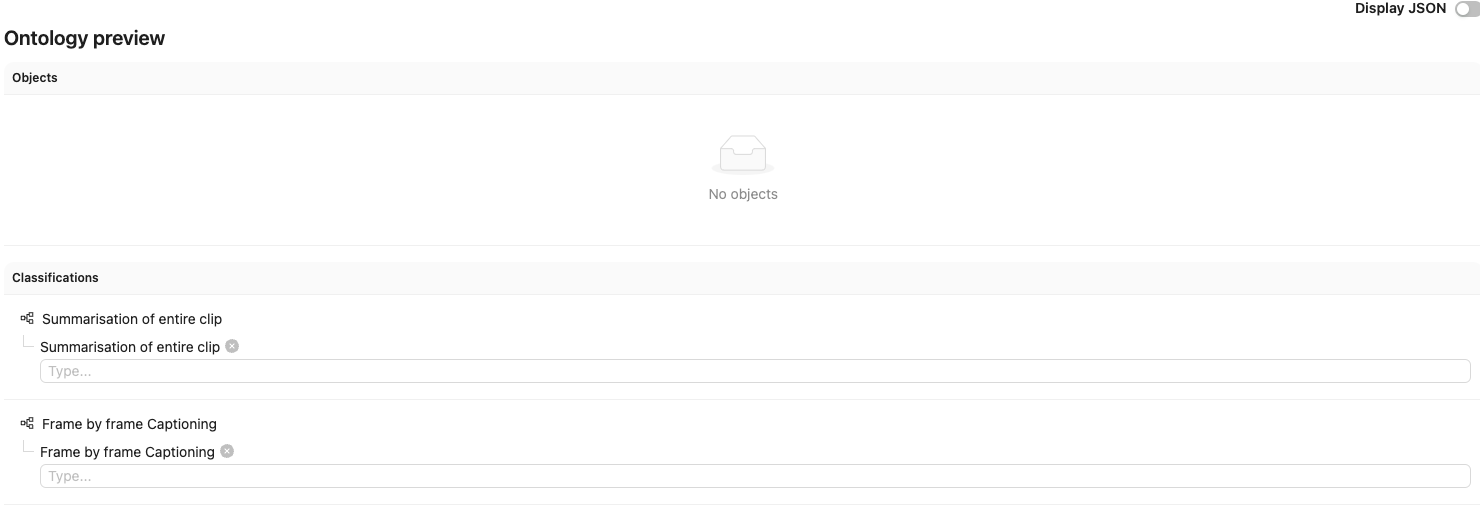

## Create a Workflow Template

Employ a simple Workflow with 2 separate Agent stages. The first "Frame Captioning" stage summerises individual frame, and the second "Semating Summarization" stage summerises the entire task.

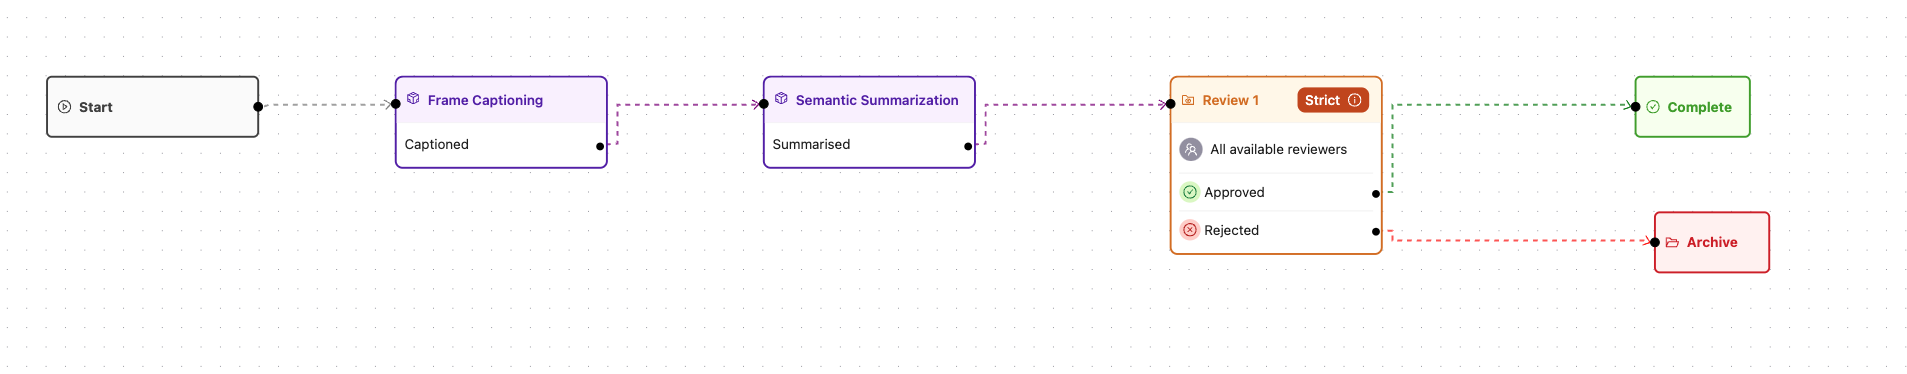

## Defining the Agent

Both agents can be defined together. When using the runner, it iterates through the defined agents, fetching all tasks at their respective stages and processing them. The system follows the natural ordering of the Workflow Graph, prioritizing earlier tasks to ensure they progress to later stages efficiently.

In [ ]:
from dataclasses import dataclass

from openai import OpenAI


# Data class to hold predictions from our model
@dataclass
class ModelPrediction:
    caption: str
    conf: float


def caption_from_openai(base64_img_url: str) -> str:
    openai_client = OpenAI()
    prompt = "Please summarise the following frame from a video. Be succinct and start immediately. Describe the frame and only the frame directly"
    response = openai_client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": base64_img_url}},
                ],
            }
        ],
    )
    return response.choices[0].message.content or "Failed to summarise"


def caption_frame(base64_img_url: str) -> ModelPrediction:
    caption = caption_from_openai(base64_img_url)
    conf = 0.5  # One could try to ask VLM on their confidence of the individual caption
    return ModelPrediction(caption=caption, conf=conf)


model = caption_frame

Ensure that you replace `<your-project-hash>` with the unique ID of your Encord Project.

In [ ]:
from typing import Iterable

from encord.objects.classification import Classification
from encord.objects.classification_instance import ClassificationInstance
from encord.objects.ontology_labels_impl import LabelRowV2
from encord.project import Project
from typing_extensions import Annotated

from encord_agents.core.data_model import Frame
from encord_agents.tasks import Depends, Runner
from encord_agents.tasks.dependencies import dep_video_iterator

# a. Define a runner that executes the agent on every task in the agent stage
runner = Runner(project_hash="<your-project-hash>")


# b. Specify the logic that goes into the "pre-label" agent node.
@runner.stage(stage="Frame Captioning")
def caption_video(
    lr: LabelRowV2,
    project: Project,
    frames: Annotated[Iterable[Frame], Depends(dep_video_iterator)],
) -> str:
    ontology = project.ontology_structure
    captions: dict[int, ModelPrediction] = {}
    # c. Loop over the frames in the video
    ontology_element: Classification = ontology.get_child_by_title("Frame by frame captioning")
    for frame_idx, frame in enumerate(frames):
        if frame_idx % 48 != 0:  # For every 48th frame in the video
            continue
        frame_dense_summarisation: ClassificationInstance = ontology_element.create_instance()
        frame_caption = model(frame.b64_encoding())
        captions[frame_idx] = frame_caption
        frame_dense_summarisation.set_answer(frame_caption.caption)
        frame_dense_summarisation.set_for_frames(frame_idx, overwrite=True)
        lr.add_classification_instance(frame_dense_summarisation, force=True)

    lr.save()
    return "Captioned"

Now, we define the summarization component of the agent. This step takes the frame-tagged captions and processes them through an LLM (which does not need to be vision-based) to generate a concise summary of the entire video.  

The prompt used for this process is directly influenced by the CogX paper, ensuring effective aggregation of individual frame captions into a coherent summary.

In [ ]:
def get_prompt(dict_frame_caption: dict[int, str]) -> str:
    summarisation_prompt = f"""
    We extracted several frames from this video and described
    each frame using an image understanding model, stored
    in the dictionary variable ‘image_captions: Dict[str: str]‘.
    In ‘image_captions‘, the key is the frame at which the image
    appears in the video, and the value is a detailed description
    of the image at that moment. Please describe the content of
    this video in as much detail as possible, based on the
    information provided by ‘image_captions‘, including
    the objects, scenery, animals, characters, and camera
    movements within the video. \n image_captions={dict_frame_caption}\n
    You should output your summary directly, and not mention
    variables like ‘image_captions‘ in your response.
    Do not include ‘\\n’ and the word ’video’ in your response.
    Do not use introductory phrases such as: \"The video
    presents\", \"The video depicts\", \"This video showcases\",
    \"The video captures\" and so on.\n Please start the
    description with the video content directly, such as \"A man
    first sits in a chair, then stands up and walks to the
    kitchen....\"\n Do not use phrases like: \"as the video
    progressed\" and \"Throughout the video\".\n
    the content of the video and the changes that occur, in
    chronological order.\n Please keep the description of this
    video within 100 English words.
    """
    return summarisation_prompt


def get_summaerised_caption(dict_frame_caption: dict[int, str]) -> str:
    prompt = get_prompt(dict_frame_caption)
    openai_client = OpenAI()
    resp = openai_client.chat.completions.create(
        messages=[
            {"role": "user", "content": prompt},
        ],
        model="gpt-4o",
    )
    return resp.choices[0].message.content or "Failed to get summarisation"

In [ ]:
@runner.stage(stage="Semantic Summarization")
def summarise_captions(lr: LabelRowV2, project: Project) -> str:
    ontology = project.ontology_structure
    ontology_element: Classification = ontology.get_child_by_title("Frame by frame captioning")
    classification_elements = lr.get_classification_instances(filter_ontology_classification=ontology_element)
    dict_frame_caption: dict[int, str] = {}
    for inst in classification_elements:
        anno = inst.get_annotations()[0]
        dict_frame_caption[anno.frame] = str(inst.get_answer())
    summarised_caption = get_summaerised_caption(dict_frame_caption)
    succint_ontology_element: Classification = ontology.get_child_by_title("Summarisation of entire clip")
    succ_inst = succint_ontology_element.create_instance()
    succ_inst.set_answer(summarised_caption)
    succ_inst.set_for_frames(frames=0)
    lr.add_classification_instance(succ_inst)
    lr.save()
    return "Summarised"

## Running the Agent

With the project, workflow, and agent defined, it's time to put everything into action. The `runner` object is callable, allowing you to execute it directly to prioritize and process your tasks efficiently.

In [ ]:
# Run the agent
runner()

Your agent now assigns labels to videos and routes them through the workflow to the annotation stage. As a result, each annotation task includes pre-existing labels (predictions).  

> 💡 To run this as a Python script, place the above code in an `agents.py` file and change:  
> ```python
> runner()
> ```
> to  
> ```python
> if __name__ == "__main__":
>     runner.run()
> ```
> This allows you to set parameters like the project hash using the command line:  
> ```bash
> python agent.py --project-hash "..."
> ```

## Outcome

With these video summaries generated, you can now use them to train your model. As mentioned earlier, a notable example is the CogX paper, which presents an open-source generative text-to-video model, though other approaches are also viable.  

Consider leveraging your internal video corpus, using this workflow to generate captions, and fine-tuning your model for your specific use case.